Try to replicate the flexpepdock server results using the parameters that the Furman lab uses in their paper: 

https://academic.oup.com/nar/article/39/suppl_2/W249/2506913#supplementary-data

the params are:
```
FlexPepDocking.release -database minirosetta_database -s start.pdb -native ref.pdb -rbMCM -torsionsMCM -ex1 -ex2aro -use_input_sc –unboundrot start.pdb -scorefile score.sc -ignore_unrecognized_res -nstruct 200 [-lowres_preoptimize]
```

and according to their initial paper at:

https://onlinelibrary-wiley-com.envoy.dickinson.edu/doi/full/10.1002/prot.22716

We implemented our refinement protocols within the Rosetta modeling framework.40 Rosetta provides well calibrated energy functions, efficient energy calculations and a battery of established conformational sampling protocols. In particular, we use the Rosetta full‐atom energy function (Rosetta ```score12```), the coarse‐grained energy function that employs a unified spheres side chains model (Rosetta centroid ```score4```), Monte‐Carlo sampling with Energy Minimization,41 and a side chain repacking protocol that relies on the Dunbrack rotamer library.55

Not sure if I should use ```score12``` or ```score4``` for the job distrib. Try 12. 

In [1]:
# my attempt to adapt the above code.

from pyrosetta import *
from pyrosetta.rosetta.core.select.residue_selector import \
	ChainSelector, OrResidueSelector, ResidueIndexSelector
from pyrosetta.rosetta.protocols.constraint_generator import \
	AddConstraints, CoordinateConstraintGenerator
from pyrosetta.rosetta.protocols.enzdes import ADD_NEW, AddOrRemoveMatchCsts
from pyrosetta.rosetta.protocols.flexpep_docking import FlexPepDockingProtocol
#from pyrosetta.rosetta.protocols.flexpep_docking import FlexPepDockingAbInitio
#import design_protease as dp


def fp_dock_init():
#     opts = '-rbMCM '
#     opts += '-torsionsMCM -ex1 -ex2aro -use_input_sc '
#     opts += '-ignore_unrecognized_res -restore_pre_talaris_2013_behavior' #need this last one with score12 score function
    
    #try some lubin opts I found in a text file:
    #opts = "-receptor_chain A -peptide_chain B -lowres_abinitio true -flexPepDocking:FlexPepDockingFlags:design_peptide true -cst_fa_weight 1.0"
    
    # this might be the closest to Furman after A LOT of reading.
    opts = "-pep_refine -ex1 -ex2aro -use_input_sc -ignore_unrecognized_res"
    init(opts)

    

def pep_run(decoy_name, n_decoys, pep_sequence=None, starts_at=None,  pdb='native_test.pdb', sf='docking'):
    
    # Score function and starting PDB
    sf = create_score_function(sf) # no idea what this sf is...
    pose = pose_from_pdb(pdb)

    # Creating FlexPepDock protocol using init options
    fpdock = FlexPepDockingProtocol()

    jd = PyJobDistributor(decoy_name, n_decoys, sf)
    while not jd.job_complete:
        pp = Pose()
        pp.assign(pose)
        fpdock.apply(pp)
        jd.output_decoy(pp)

def pep_multicore_run(input_path, destination_path, filenames, nstructs):
    import time
    from multiprocessing import Pool
    
    timestr = time.strftime("%Y%m%d-%H%M%S")

    with Pool() as p:
        work = [(destination_path+filename[:-4]+"-"+timestr+"_"+str(n), nstructs, None, None, input_path+filename, 'score12') for n, filename in enumerate(filenames)]
        p.starmap(pep_run, work)

In [2]:
fp_dock_init()

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.CentOS.python37.Release r248 2020.10+release.46415fa 46415fa3e9decb8b6e91a4e065c15543eb27a461 http://www.pyrosetta.org 2020-03-05T09:09:24
core.init: {0} command: PyRosetta -pep_refine -ex1 -ex2aro -use_input_sc -ignore_unrecognized_res -database /home/colin/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=1288357858 seed_offset=0 real_seed=1288357858 thread_index=0
basic.random.init_random_generator: {0} RandomGenerator:init: Normal mode, seed=1288357858 RG_type

In [3]:
from os import listdir
pdbs = listdir('./smbits/')
print(pdbs)

['peptide79.pdb', 'peptide104.pdb', 'native_test.pdb', 'peptide86.pdb', 'peptide114.pdb', 'peptide128.pdb', 'peptide99.pdb', 'peptide101.pdb', 'peptide78.pdb']


In [ ]:
pep_multicore_run('./smbits/', './decoys/', pdbs, 200)

core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: {0} smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: {0} smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: {0} smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: {0} smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: {0} smooth_etab

In [27]:
from os import listdir
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

date_time = "20210321-224053"
kds = kds = {'peptide86':0.7E-9,
       'peptide78':3.4E-9,
       'peptide79':8.5E-9,
       'peptide99':1.8E-7,
       'peptide128':2.8E-7,
       'native_test':0.9E-6,
       'peptide104':1.3E-6,
       'peptide101':2.5E-6,
       'peptide114':1.9E-4
       }

l = listdir("./decoys/")
fascs = []
for f in l:
    if ".fasc" in f:
        if date_time in f:
            fascs.append(f)

print(fascs)

data = pd.read_json("./decoys/"+fascs[0], orient='records', lines=True)

for f in fascs[1:]:
    d = pd.read_json("./decoys/"+f, orient='records', lines=True)
    data = data.append(d)

print(data.shape)

peptide_names = []
for i, r in data.iterrows():
    s = r['filename'].split('-')
    s = s[0].split('/')
    name = s[2]
    peptide_names.append(name)
    
data['peptide'] = peptide_names
#print(data.head())

peptides = set(data['peptide'])
dfs = []

for peptide in peptides:
    subdata = data[data['peptide']==peptide]
    subdata['kds'] = kds[peptide]
    
    stdev_total_score = np.std(subdata['total_score'])
    mean_total_score = np.mean(subdata['total_score'])
    print("{}: {} plus minus {}".format(peptide, mean_total_score, stdev_total_score))

    threshold_total_score = mean_total_score - 2 * stdev_total_score

    #dfs.append(subdata[subdata['total_score']<threshold_total_score])
    dfs.append(subdata.sort_values('total_score')[:10])
    
significant_structures = pd.concat(dfs)
print(significant_structures.shape)

['peptide78-20210321-224053_8.fasc', 'native_test-20210321-224053_2.fasc', 'peptide99-20210321-224053_6.fasc', 'peptide86-20210321-224053_3.fasc', 'peptide101-20210321-224053_7.fasc', 'peptide104-20210321-224053_1.fasc', 'peptide128-20210321-224053_5.fasc', 'peptide114-20210321-224053_4.fasc', 'peptide79-20210321-224053_0.fasc']
(1800, 24)
peptide101: -265.3249260297171 plus minus 8.744104349555007
peptide114: -268.91460024499514 plus minus 8.578976621749586
peptide99: -270.0401008190245 plus minus 8.439072420798022
peptide79: -266.1159633653119 plus minus 12.129837159425591
native_test: -277.2761672866281 plus minus 10.440368617431202
peptide86: -269.2010544819474 plus minus 9.47022738964075
peptide128: -270.9452079428005 plus minus 8.729082471606914
peptide78: -265.4716835434263 plus minus 12.497768299374487
peptide104: -265.2738625887421 plus minus 7.918881646466768
(90, 26)


/home/colin/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


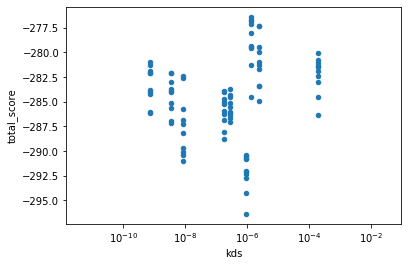

In [28]:
significant_structures.plot('kds', 'total_score', kind='scatter', logx=True)

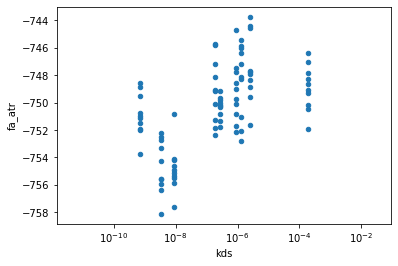

In [29]:
significant_structures.plot('kds', 'fa_atr', kind='scatter', logx=True)

In [26]:
# Try the Spearman correlation
significant_structures.corr('spearman')['kds']

nstruct              NaN
dslf_ca_dih          NaN
dslf_cs_ang          NaN
dslf_ss_dih          NaN
dslf_ss_dst          NaN
fa_atr          0.533737
fa_dun          0.025985
fa_intra_rep   -0.232625
fa_pair         0.003757
fa_rep         -0.183852
fa_sol         -0.269445
hbond_bb_sc     0.257399
hbond_lr_bb     0.073113
hbond_sc        0.267241
hbond_sr_bb    -0.231661
omega          -0.065599
p_aa_pp         0.501915
pro_close       0.130888
rama            0.675460
ref             0.084318
total_score     0.523740
kds             1.000000
Name: kds, dtype: float64

This is looking a lot better. Move this to a new repository for further development.